In [9]:
!pip install keras-tuner

     -------------------------------------- 176.1/176.1 kB 2.1 MB/s eta 0:00:00


In [39]:
batch_size = 16
BUFFER = 100
MONITOR = "val_accuracy"
BASE_EPOCHS = 100
BASE_PATIENCE = 3
MIN_DELTA = .02
LOGS = "logs"
DIR_OUT = "kt_out"
PROJECT = "kt_basics"
FACTOR = 3
VALIDATION = .2

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  batch_size = 32
  !pip install keras_tuner
  !pip install wget

In [3]:
pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=1338a3c776e1e88a35c7722ed284530f34407a7d2dc2ef19f0d99783fffd3a86
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os, warnings
import datetime
import keras_tuner as kt
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os, shutil
import warnings
import random
warnings.filterwarnings('ignore')

In [47]:
from tensorflow.keras.callbacks import EarlyStopping


# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
<li>

### Download and Unzip Data

In [65]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))
import wget
import zipfile
zip_name = "train.zip"

url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

if not os.path.exists(zip_name):
    wget.download(url, zip_name, bar=bar_custom)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [66]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(224,224)
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'
batch_size = 16

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Preparation

In [67]:
# Get Vegetable Names
class_names = train_ds.class_names
# Create dict to map vegetable name to class number
class_map = dict([(k, v) for k, v in enumerate(class_names)])

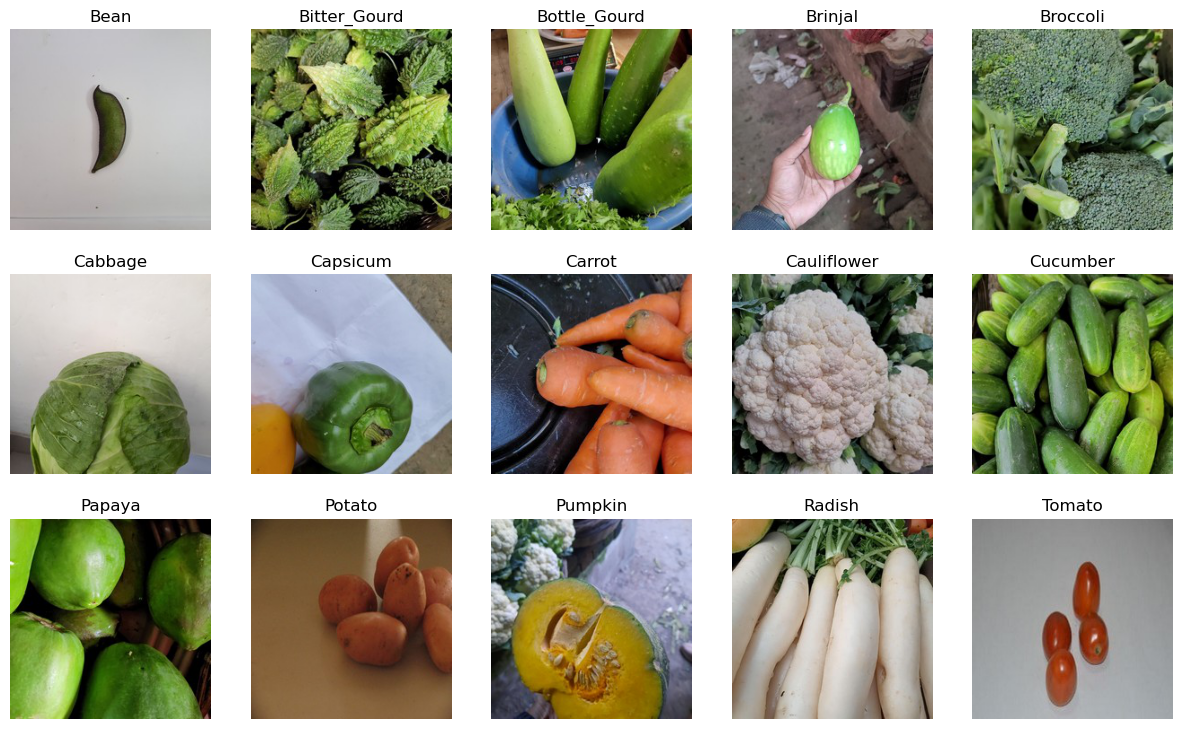

In [68]:
#  In the training set view first image of each category
def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(15,9))
    for i, cat in enumerate(image_categories):
        
        # Load image from each category
        image_path = train_dir + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = load_img(first_image_path)
        img_arr = img_to_array(img)/255.0
        
        
        # Create a subplot and plot the images
        plt.subplot(3, 5, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Function call
plot_images(class_names)

In [69]:
#To create smaller subsets of data for testing purposes, we used the take() method from the TensorFlow datasets library. 
# Specifically, we selected 2048 samples for the training subset and 1024 samples for the validation subset. 
# To ensure that the data is in the appropriate scale, we trained a neural network with the sole purpose of rescaling the data.

# Create subsets of train_ds and val_ds for faster training
train_ds_sample = train_ds.take(2048)
val_ds_sample = val_ds.take(1024)

#Neural network for rescaling values
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [70]:
#I utilized the AUTOTUNE parameter in TensorFlow to dynamically optimize the performance of our data pipeline at runtime.
#I applied the map() method to rescale our data by normalizing pixel values.
#I used the batch() method to create batches of a specified size.
#I optimize our data pipeline even further, we used the prefetch() method to prepare the next batch and take advantage of AUTOTUNE to optimize performance.

# Tune values dynamically at runtime
autotune = tf.data.AUTOTUNE
# Set up tensorflow pipeline for training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=autotune)
# Set up tensorflow pipeline for validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=autotune)

In [71]:
# Pipeline for training subsets
train_ds_sample = train_ds_sample.map(lambda x, y: (rescale(x), y))
train_ds_sample = train_ds_sample.batch(batch_size)
train_ds_sample = train_ds_sample.prefetch(buffer_size=autotune)

val_ds_sample = val_ds_sample.map(lambda x, y: (rescale(x), y))
val_ds_sample = val_ds_sample.batch(batch_size)
val_ds_sample = val_ds_sample.prefetch(buffer_size=autotune)

## Custom Model Training

In [72]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Helper to plot accuracy
def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [73]:
#limited the number of hyperparameters we tested in our model to avoid performing an excessive number of trials.
#Restricted the number of layers to a maximum of 5 and used the same padding and kernel size for each layer.
#For the classification component of our model, incorporated a Dense layer with 32 neurons before our final prediction layer. 
#Used softmax activation to suit our classification problem.

# Create hypermodel for tuning
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 5)): # 1-5 Conv2D layers
        # Different kernel numbers each layer
        # Same kernel size every layer,
        # Same padding every layer
        model.add(Conv2D(hp.Choice("kernel_L"+str(i), values=[32, 64, 128, 256, 512]), kernel_size=hp.Choice("kernel_size", values=[3, 5]), input_shape=(150, 150, 3), activation="relu", padding=hp.Choice('padding', values=["same", "valid"])))
        model.add(MaxPooling2D())
        model.add(Dropout(0.2))
    
    # Dense layers for classification
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(15, activation="softmax")) # Softmax for multiclass classification

    # Learning rate hyperparameter choices
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), # Adam Optimizer taking in hyperparameter choices
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [74]:
#After utilizing the hyperband tuner to determine the optimal hyperparameters, 
#built a model using these hyperparameters and trained it on the training and validation sets.
#Monitored the loss plot to detect signs of underfitting or overfitting, which prompted adjusting hyperparameters.
#Found that our initial dense layer parameters worked well for our model.
#Iterative process of hyperparameter adjustments and model tuning yielded the following parameters: 4 layers, with Conv2D Layer 1 having 256 kernels, Conv2D Layer 2 having 512 kernels, and Conv2D Layers 3 and 4 having 128 kernels each.
#Used same padding and a learning rate of 0.0001 with a kernel size of 3.
#The final model architecture is defined in a function called final_model(), which implements early stopping to obtain the best weights from training and saves them as an h5 file. 
# This file can then be loaded into the compiled model and used for testing.

def final_model():

    model = Sequential()

    # Layer 1
    model.add(Conv2D(256, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 2
    model.add(Conv2D(512, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 3
    model.add(Conv2D(128, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 4
    model.add(Conv2D(128, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Classification Layers
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(15, activation="softmax"))
    # Compile Model
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    )

    return model

In [75]:
# Switch for training and tuning model
training_mode = False

# Weights URL 
weights_url = 'https://github.com/Isaacjimoh/ItML_Project_2_Students/blob/main/custom_best_weights'

In [78]:
#If training_mode is set to True, hyperparameter tuning will begin using the training and validation subsets. 
#Once the best hyperparameters are determined, a model will be constructed using these hyperparameters and will be trained using all of the training and validation data. 
#The resulting weights will be saved as an h5 file called custom_best_weights.

#However, If training_mode is set to False, the weights will be loaded from a URL into a pre-defined model with the architecture specified above (final_model()).

if training_mode:
    # Initialize Hyperband tuner
    tuner = kt.Hyperband(hypermodel = build_model,
                     objective=MONITOR,
                     max_epochs=10,
                     factor=3,
                     directory=DIR_OUT,
                     project_name=PROJECT, 
                     overwrite=True)
    # Initialize early stopping, restore model to weights from best epoch, stop if validation accuracy doesn't improve after 3 epochs
    stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)
    
    # Get results from different hyperparaters using a subset of training and validation data for speed
    tuner.search(train_ds_sample, epochs=3, validation_data=val_ds_sample, callbacks=[stopping])
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print best hyperparameters
    numLayers = best_hps.get('num_layers')
    print('Layers:', numLayers)
    for i in range(numLayers):
        print(f'Layer {i+1} # kernels: {best_hps.get("kernel_L"+str(i))}')
    print('Padding choice:', best_hps.get("padding"))
    print('Learning rate:', best_hps.get("learning_rate"))
    print('Kernel size:', best_hps.get('kernel_size'))

    # Build best model
    best_model.build(input_shape=(None, 150, 150, 3))
    best_model.summary()

    # Train on all of training and validation data
    train_log = best_model.fit(train_ds, epochs=BASE_EPOCHS, verbose=1, callbacks=[stopping], validation_data=val_ds)
    # Plot loss to monitor overfitting/underfitting
    plot_loss(train_log)
    # Print best epoch and its validation accuracy
    val_acc_per_epoch = train_log.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch:d}')
    print(f'Accuracy: {max(val_acc_per_epoch)}')

    # Save weights
    best_model.save_weights('custom_best_weights', overwrite=False, save_format='h5')


    if not os.path.exists(weights_file):
        wget.download(weights_url, weights_file, bar=bar_custom)

    # Create final model
    final = final_model()
    # Load saved weights
    final.load_weights(weights_file) 


## Transfer Learning Model

In [79]:
#VGG16 model was chosen for transfer learning since the team was familiar with it
#The 'top' was removed and custom classification layers were added to the model
#The same classification layers used in the custom model were used in the transfer learning model
#After initial training, fine-tuning was explored to further improve training accuracy
#Learning rate was set low at 1e-5 to avoid undoing too much of the VGG16's pretraining on substantially more data
transfer_stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)

In [110]:
# Load VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False ## Not trainable weights

# Add Dense Layers
flatten_layer = Flatten()
dense_layer_1 = Dense(32, activation='relu', )
prediction_layer = Dense(15, activation='softmax')

transfer_model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

transfer_model.summary()

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_50 (Flatten)        (None, 8192)              0         
                                                                 
 dense_100 (Dense)           (None, 32)                262176    
                                                                 
 dense_101 (Dense)           (None, 15)                495       
                                                                 
Total params: 14,977,359
Trainable params: 262,671
Non-trainable params: 14,714,688
_________________________________________________________________


In [111]:
# Unlock VGG16 layers for fine tuning
base_model.trainable = True
transfer_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_50 (Flatten)        (None, 8192)              0         
                                                                 
 dense_100 (Dense)           (None, 32)                262176    
                                                                 
 dense_101 (Dense)           (None, 15)                495       
                                                                 
Total params: 14,977,359
Trainable params: 14,977,359
Non-trainable params: 0
_________________________________________________________________


In [112]:
# Stop training if there are no improvements after 3 epochs
transfer2_stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)


In [113]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

## Test Best Models and Illustrate Results

In [114]:
test_dir='Vegetable Images/test'
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 3000 files belonging to 15 classes.


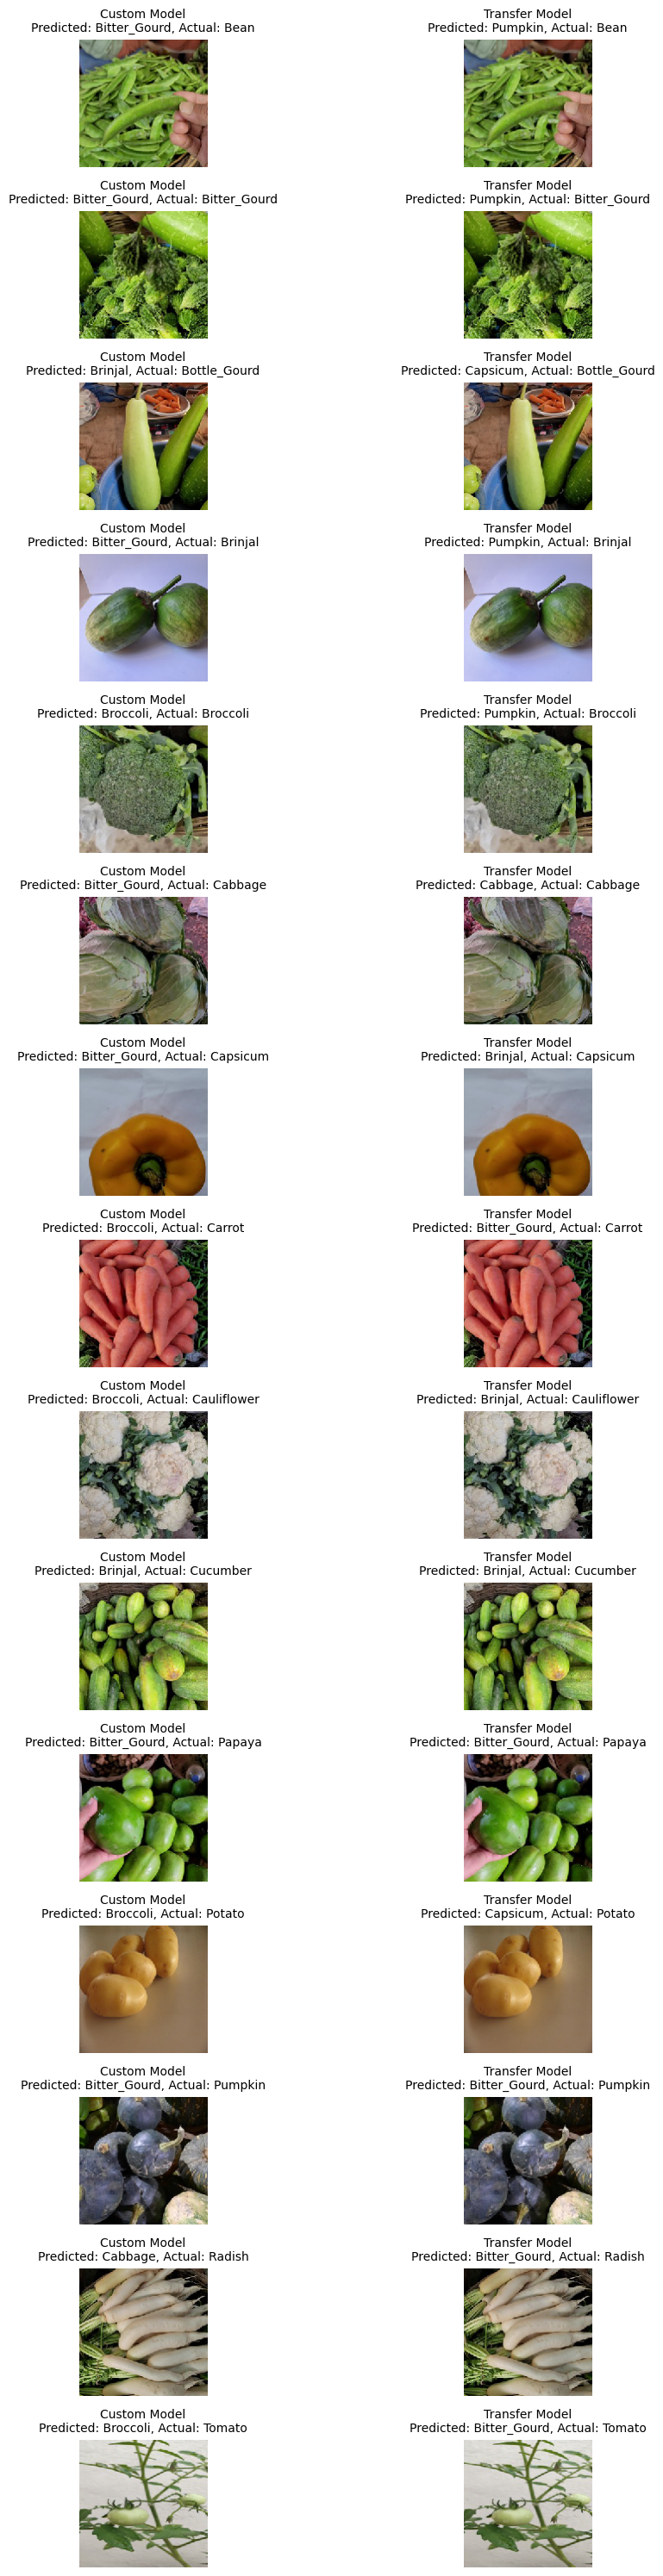

In [116]:
import random
# Create a figure
fig, ax = plt.subplots(15, 2, figsize=(12, 30))
row = 0
for cat in class_names:
    
    # Load image for the each category
    image_path = test_dir + '/' + cat
    images_in_folder = os.listdir(image_path)
    random_img_from_folder = random.choice(images_in_folder) # choose random image from folder
    random_img_from_folder = os.path.join(image_path, random_img_from_folder) # get path name
    
    img = load_img(random_img_from_folder, target_size=(150, 150)) # load image
    img_arr = img_to_array(img) / 255.0 # convert to array and rescale
    
    img_input = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2])) # Ensure shape is consistent with model input layer

    custom_label = np.argmax(final.predict(img_input, verbose=0)) # Custom prediction
    custom_vegetable = class_map[custom_label] # convert to label

    transfer_label = np.argmax(transfer_model.predict(img_input, verbose=0)) # transfer prediction
    transfer_vegetable = class_map[transfer_label] # convert to label

    ax[row, 0].imshow(img)
    ax[row, 0].set_title("Custom Model\nPredicted: {}, Actual: {}".format(custom_vegetable, cat), size=10)
    ax[row, 0].grid()
    ax[row, 0].axis('off')

    ax[row, 1].imshow(img)
    ax[row, 1].set_title("Transfer Model\nPredicted: {}, Actual: {}".format(transfer_vegetable, cat), size=10)
    ax[row, 1].grid()
    ax[row, 1].axis('off')

    row += 1

plt.tight_layout()
plt.show()

In [118]:
def plot_confusion_matrix(actual, predicted, classNames, title):
    cm = confusion_matrix(actual, predicted)
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='flare_r', fmt='d', xticklabels=classNames, yticklabels=classNames)
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    ax1.set_title(title)
    plt.show()

In [120]:
custom_y_pred = []  # store predicted labels
custom_y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   custom_y_true.append(np.argmax(label_batch, axis=-1))
   # compute predictions
   custom_preds = final.predict(image_batch, verbose=0)
   # append predicted labels
   custom_y_pred.append(np.argmax(custom_preds, axis=-1))

# convert the true and predicted labels into tensors
custom_correct_labels = tf.concat([item for item in custom_y_true], axis = 0)
custom_predicted_labels = tf.concat([item for item in custom_y_pred], axis = 0)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_25/dense_46/Relu' defined at (most recent call last):
    File "c:\Users\HP\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\HP\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\HP\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\HP\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\HP\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_8252\3238029057.py", line 9, in <module>
      custom_preds = final.predict(image_batch, verbose=0)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_25/dense_46/Relu'
Matrix size-incompatible: In[0]: [16,25088], In[1]: [10368,32]
	 [[{{node sequential_25/dense_46/Relu}}]] [Op:__inference_predict_function_29521]

In [122]:
plot_confusion_matrix(custom_correct_labels, custom_predicted_labels, class_names, 'Custom Model Confusion Matrix')

NameError: name 'custom_correct_labels' is not defined

In [121]:
transfer_y_pred = []  # store predicted labels
transfer_y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   transfer_y_true.append(np.argmax(label_batch, axis=-1))
   # compute predictions
   transfer_preds = transfer_model.predict(image_batch, verbose=0)
   # append predicted labels
   transfer_y_pred.append(np.argmax(transfer_preds, axis=-1))

# convert the true and predicted labels into tensors
transfer_correct_labels = tf.concat([item for item in transfer_y_true], axis = 0)
transfer_predicted_labels = tf.concat([item for item in transfer_y_pred], axis = 0)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_52/dense_100/Relu' defined at (most recent call last):
    File "c:\Users\HP\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\HP\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\HP\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\HP\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\HP\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\HP\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_8252\1763058453.py", line 9, in <module>
      transfer_preds = transfer_model.predict(image_batch, verbose=0)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\HP\anaconda3\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_52/dense_100/Relu'
Matrix size-incompatible: In[0]: [16,25088], In[1]: [8192,32]
	 [[{{node sequential_52/dense_100/Relu}}]] [Op:__inference_predict_function_29835]

In [123]:
plot_confusion_matrix(transfer_correct_labels, transfer_predicted_labels, class_names, 'Transfer Model Confusion Matrix')

NameError: name 'transfer_correct_labels' is not defined